In [1]:
import copy
import numpy as np
import pandas as pd
import scipy.stats
import dftools
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.18/00


In [2]:
plt.style.use("cms")

In [3]:
_df_data = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "Data")
_df_mc = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MC")
_df_mc_smooth = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MCSmooth")
_df_mc_p4 = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MCPoly4")
_df_mc_flat = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MCFlat")

_df_data = _df_data.loc[~_df_data.index.duplicated(keep="first")]
_df_mc = _df_mc.loc[~_df_mc.index.duplicated(keep="first")]
_df_mc_smooth = _df_mc_smooth.loc[~_df_mc_smooth.index.duplicated(keep="first")]
_df_mc_p4 = _df_mc_p4.loc[~_df_mc_p4.index.duplicated(keep="first")]
_df_mc_flat = _df_mc_flat.loc[~_df_mc_flat.index.duplicated(keep="first")]

## Modify dataframes

Alter the dataframes, for example, to make or break correlations between systematic uncertainties, remove variations from particular sources, or switch to polyfit smoothing or a flat systematic

### Rename nuisances

In [4]:
region_mapping = {
    "Monojet": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "MonojetQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleTau": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonMinus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonPlus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "DoubleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig2MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
}

for region, mapping in region_mapping.items():
    selection = (_df_mc.index.get_level_values("variation")=="") & (_df_mc.index.get_level_values("region")==region)
    tdf = _df_mc.loc[selection,:]
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Up")) & (_df_mc.index.get_level_values("region")==region)
    tdf_up = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Up": v.format(region=region)+"Up" for k, v in mapping.items()},
    )
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Down")) & (_df_mc.index.get_level_values("region")==region)
    tdf_do = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Down": v.format(region=region)+"Down" for k, v in mapping.items()},
    )
    _df_mc = pd.concat([tdf, tdf_up, tdf_do, _df_mc.loc[_df_mc.index.get_level_values("region")!=region,:].copy()], axis=0, sort=False)

## Remove nuisances

In [5]:
_df_mc.loc[("SingleElectron", "WJetsToLNu"),:].index.get_level_values("variation").unique()

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Index(['', 'alphasDown', 'alphasUp', 'btagSFDown', 'btagSFUp', 'd1kewDown',
       'd1kewUp', 'd1kqcdDown', 'd1kqcdUp', 'd2kewwDown', 'd2kewwUp',
       'd2kewzDown', 'd2kewzUp', 'd2kqcdDown', 'd2kqcdUp', 'd3kewwDown',
       'd3kewwUp', 'd3kewzDown', 'd3kewzUp', 'd3kqcdDown', 'd3kqcdUp',
       'dkmixDown', 'dkmixUp', 'eleEnergyScaleDown', 'eleEnergyScaleUp',
       'eleIdIsoTightDown', 'eleIdIsoTightUp', 'eleIdIsoVetoDown',
       'eleIdIsoVetoUp', 'eleRecoDown', 'eleRecoUp', 'eleTrigDown',
       'eleTrigUp', 'jerSFDown', 'jerSFUp', 'jesTotalDown', 'jesTotalUp',
       'lhePdfWeightDown', 'lhePdfWeightUp', 'lheScaleWeightDown',
       'lheScaleWeightUp', 'lumiDown', 'lumiUp',
       'metTrigMuonMultiplicitySystDown', 'metTrigMuonMultiplicitySystUp',
       'metTrigReferenceTriggerSystDown', 'metTrigReferenceTriggerSystUp',
       'metTrigRegionSystDown', 'metTrigRegionSystUp', 'muonIdLooseStatDown',
       'muonIdLooseStatUp', 'muonIdLooseSystDown', 'muonIdLooseSystUp',
       'muon

In [6]:
region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): [
        "lheScaleWeight", "eleTrig",
        #"d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
        #"d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
        #"lumi",
    ],
    ("SingleElectron", "WJetsToLNu"): [
        "lheScaleWeight", "muonTrig",
        #"d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
        #"d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
        #"lumi",
    ],
    ("SingleTau", "WJetsToLNu"): [
        "lheScaleWeight", "muonTrig", "eleTrig",
    ],
    ("SingleMuon", "QCD"): ["eleTrig"],
    ("SingleMuon", "MinorBkgs"): ["eleTrig"],
    ("SingleElectron", "MinorBkgs"): ["muonTrig"],
    ("SingleTau", "QCD"): ["eleTrig", "muonTrig"],
    ("SingleTau", "MinorBkgs"): ["eleTrig", "muonTrig"],
}

drops = [
    (r, p, v+"Up")
    for (r, p), vs in region_process_variations.items()
    for v in vs
] + [
    (r, p, v+"Down")
    for (r, p), vs in region_process_variations.items()
    for v in vs
]
_df_mc = _df_mc.drop(drops, errors='ignore')

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


## Use gaussian filter smoothing

In [7]:
wjets = [
    "lhePdfWeight", "jesTotal", "jerSF", "unclust", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst",
    "muonIdTightStat", "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "btagSF",
]
minor_bkgs = [
    "lhePdfWeight", "lheScaleWeight", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat",
    "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]
qcd = [
    "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat", "muonIsoLooseSyst",
    "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]

region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): wjets,
    ("SingleMuon", "MinorBkgs"): minor_bkgs,
    ("SingleMuon", "QCD"): qcd,
    ("SingleElectron", "WJetsToLNu"): wjets,
    ("SingleElectron", "MinorBkgs"): minor_bkgs,
    ("SingleTau", "WJetsToLNu"): wjets,
    ("SingleTau", "MinorBkgs"): minor_bkgs,
    ("SingleTau", "QCD"): qcd,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_smooth.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


## Use polyfit smoothing

In [8]:
wjets = [
    "d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d3keww", "dkmix",
]

region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): wjets,
    ("SingleElectron", "WJetsToLNu"): wjets,
    ("SingleTau", "WJetsToLNu"): wjets,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_p4.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


## Use flat systematic


In [9]:
qcd = ["jesTotal", "jerSF", "unclust", "pileup", "eleReco", "btagSF"]
minors = ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight", "btagSF"]

process_variations = {
    ("SingleMuon", "WJetsToLNu"): ["jerSF"],
    ("SingleMuon", "MinorBkgs"): minors,
    ("SingleMuon", "QCD"): qcd,
    ("SingleElectron", "WJetsToLNu"): [],
    ("SingleElectron", "MinorBkgs"): minors,
    ("SingleTau", "MinorBkgs"): minors,
    ("SingleTau", "QCD"): qcd,
}

for (region, process), variations in process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            _df_mc.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ] = _df_mc_flat.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ]

## Symmetrize

In [10]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "tauIdTightUp"
tdf_do["variation"] = "tauIdTightDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightDown"),:] = tdf_do

## Split JES uncertainties

In [12]:
bin_min = _df_data.index.get_level_values("bin_min").unique().values
bin_max = _df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [13]:
for idx, bval in enumerate(bin_min):
    nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""), :].reset_index("variation", drop=True)
    var_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
    var_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
    
    selection = nom.index.get_level_values("bin_min")==bval
    var_up.loc[selection,:] = nom.loc[selection,:]
    var_down.loc[selection,:] = nom.loc[selection,:]
    
    var_up["variation"] = "jesTotalB{}Up".format(idx)
    var_down["variation"] = "jesTotalB{}Down".format(idx)
    
    order = ["region", "process", "variation", "bin_min", "bin_max"]
    var_up = var_up.set_index("variation", append=True).reorder_levels(order).sort_index()
    var_down = var_down.set_index("variation", append=True).reorder_levels(order).sort_index()
    
    _df_mc = pd.concat([_df_mc, var_down, var_up], axis=0, sort=True)
    _df_mc.tail(5)

In [14]:
#nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""), :].reset_index("variation", drop=True)
#var_low_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#var_low_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#var_high_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#var_high_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#
#selection = nom.index.get_level_values("bin_min")>1000.
#var_low_up.loc[selection,:] = nom.loc[selection,:]
#var_low_down.loc[selection,:] = nom.loc[selection,:]
#
#var_high_up.loc[~selection,:] = nom.loc[~selection,:]
#var_high_down.loc[~selection,:] = nom.loc[~selection,:]
#
#var_low_up["variation"] = "jesTotalLowUp"
#var_low_down["variation"] = "jesTotalLowDown"
#var_high_up["variation"] = "jesTotalHighUp"
#var_high_down["variation"] = "jesTotalHighDown"
#
#order = ["region", "process", "variation", "bin_min", "bin_max"]
#var_low_up = var_low_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_low_down = var_low_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_high_up = var_high_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_high_down = var_high_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#
#_df_mc = pd.concat([_df_mc, var_low_down, var_low_up, var_high_down, var_high_up], axis=0, sort=True)
#_df_mc.tail(5)

In [15]:
df_data = _df_data.unstack().unstack().loc[[
    ("MET", "Monojet"),
    ("MET", "MonojetQCD"),
    ("MET", "SingleMuon"),
    ("MET", "SingleMuonPlus"),
    ("MET", "SingleMuonMinus"),
    ("MET", "SingleMuonQCD"),
    ("MET", "DoubleMuon"),
    ("MET", "SingleTau"),
    ("SingleElectron", "SingleElectron"),
    ("SingleElectron", "SingleElectronPlus"),
    ("SingleElectron", "SingleElectronMinus"),
    ("SingleElectron", "SingleElectronQCD"),
    ("SingleElectron", "DoubleElectron"),
]].stack().stack().reset_index("trigger").drop("trigger", axis=1)
df_data.head(5)

count     sum_w    sum_ww
region  bin_min bin_max                              
Monojet 200.0   220.0    100530.0  100530.0  100530.0
        220.0   250.0    142330.0  142330.0  142330.0
        250.0   280.0    102427.0  102427.0  102427.0
        280.0   310.0     66110.0   66110.0   66110.0
        310.0   340.0     41367.0   41367.0   41367.0

In [16]:
df_mc = _df_mc.copy(deep=True)
df_mc.head(30)

sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928
                                340.0   370.0    1475.857454    53.926664
                                370.0   400.0     992.210351    37.620910
                                400.0   430.0     663.230560    28.511451
                                430.0   470.0     560.985071    27.581216
                                470.0   510.0     344.081583    17.901991
                                510.0   550.0     224.266128    11.301424
                                550.0   590.0     143.025033     7.196915
                                590.0   640.0     115.355197     5.262883
                                640.0   690.0      68.455105     2.213242
                                690.0   740.0      40.639383     0.601003
                                740.0   790.0      25.331025     0.164831
                                790.0   840.0      17.234054     0.077535
                                840.0   900.0      12.872755     0.056071
                                900.0   960.0       7.699648     0.031386
                                960.0   1020.0      4.818195     0.020460
                                1020.0  1090.0      3.480534     0.013794
                                1090.0  1160.0      2.135376     0.008295
                                1160.0  1250.0      1.498013     0.005933
                                1250.0  1400.0      1.120919     0.004172
                                1400.0  1550.0      0.683578     0.002718
           MinorBkgs            200.0   220.0     183.419165   171.793242
                                220.0   250.0     317.971478   352.310804
                                250.0   280.0     221.964530   325.758244
                                280.0   310.0     215.624429   236.232757
                                310.0   340.0     168.794255   147.271603

## Run fits

In [17]:
bin_min = df_data.index.get_level_values("bin_min").unique().values
bin_max = df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [18]:
df_mc.index.get_level_values("variation").unique()

Index(['', 'alphasUp', 'btagSFUp', 'd1kewUp', 'd1kqcdUp', 'd2kewwUp',
       'd2kewzUp', 'd2kqcdUp', 'd3kewwUp', 'd3kewzUp',
       ...
       'jesTotalB20Down', 'jesTotalB20Up', 'jesTotalB21Down', 'jesTotalB21Up',
       'jesTotalB22Down', 'jesTotalB22Up', 'jesTotalB23Down', 'jesTotalB23Up',
       'jesTotalB24Down', 'jesTotalB24Up'],
      dtype='object', name='variation', length=159)

In [25]:
bins = (bin_min, bin_max)

regions = {
    "SingleMuon":     ["WJetsToLNu", "MinorBkgs", "QCD"],
    "SingleElectron": ["WJetsToLNu", "MinorBkgs"],
    "SingleTau":      ["WJetsToLNu", "MinorBkgs", "QCD"],
}

config ={
    "regions": regions,
    "parameters": [
        {"name": "rWJetsToLNu",        "value": 1., "limit": (None, None), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToTauNuNorm",  "value": 1., "limit": (None, None), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToTauNuShape", "value": 0., "limit": (None, None), "fixed": False, "constraint": "free"},
        
        {"name": "metTrig0MuSyst",              "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig1MuSyst",              "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "metTrig2MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrigReferenceTriggerSyst", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "metTrig{}Syst".format(r), "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"}
        for r in ["Monojet", "SingleMuon", "DoubleMuon", "SingleTau", "MonojetQCD", "SingleMuonQCD", "DoubleMuonQCD"] if r in regions.keys()
    ] + [
        {"name": "muonIdLooseSyst",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdLooseStat",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightSyst",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightStat",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseSyst", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseStat", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightSyst", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightStat", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonTrig",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonPtScale",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "eleIdIsoTight",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "eleIdIsoVeto",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "eleReco",        "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "eleTrig",        "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "eleEnergyScale", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "photonIdLoose",       "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "photonPixelSeedVeto", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "photonEnergyScale",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "tauIdVLoose", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "tauIdTight",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauPtScale",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "btagSF",      "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "jesTotal",    "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "jesTotalLow",    "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "jesTotalHigh",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB0",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB1",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB2",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB3",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB4",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB5",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB6",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB7",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB8",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB9",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB10",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB11",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB12",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB13",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB14",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB15",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB16",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB17",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB18",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB19",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB20",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB21",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB22",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB23",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotalB24",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jerSF",       "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "unclust",     "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        
        {"name": "lumi",      "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "pileup",    "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "prefiring", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        
        {"name": "d1kqcd",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kqcd",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kqcd",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d1kew",          "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kewz",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d2keww",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kewz",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d3keww",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "dkmix",          "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "alphas",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "lhePdfWeight",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "lheScaleWeight", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "{}_mcstat_bin{}".format(r, idx), "value": 0., "limit": (None, None), "fixed": False, "constraint": "gamma"}
        for r in regions.keys()
        for idx in range(len(bin_min))
    ],
    "scale_functions": {
        ("SingleMuon",     "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']",
        ("SingleElectron", "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']",
        ("SingleTau",      "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']*(p['rWJetsToTauNuNorm'] + p['rWJetsToTauNuShape']*(x * (w.sum())/((x*w).sum()) - 1.))",
    }
}

In [26]:
len(config["parameters"])

142

## Asimov fit

In [27]:
#model = dftools.fitting.NLLModel2(df_data, df_mc, config, same_bin_widths=True)
#minimizer = model.fit(asimov=True, migrad=False, minos=False)
#minimizer.migrad(ncall=100_000)

In [28]:
#results = dftools.fitting.run_impacts(
#    minimizer.parameters, "rWJetsToLNu",
#    nll_args=(df_data, df_mc, bins, config),
#    nll_kwargs=dict(same_bin_widths=True),
#    fit_kwargs=dict(asimov=True, migrad=False, minos=False),
#    migrad_kwargs=dict(ncall=100_000),
#    pysge_function="sge_submit",
#    pysge_args=("zfit", "_ccsp_temp"),
#    pysge_kwargs=dict(options="-q hep.q", dill_kw={"recurse": False}),
#    params_guess=list(minimizer.args),
#)

In [29]:
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
#pd.set_option('display.max_rows', None)
#df = pd.DataFrame(results)
#df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
#df = df.sort_values("envelope", ascending=False).reset_index(drop=True).set_index(["param", "poi"])
#df.loc[~df.index.get_level_values("param").str.contains("mcstat"),:]

## Observed fit

In [30]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
minimizer = model.fit(migrad=False, minos=False)
minimizer.migrad(ncall=100_000)

------------------------------------------------------------------
| FCN = 1386                    |   Ncalls=68208 (68208 total)   |
| EDM = 0.000131 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rWJetsToLNu                 |   1.14    |   0.05    |            |            |         |         |       |
| 1  | rWJetsToTauNuNorm           |   1.031   |   0.016   |            |            |         |         |       |
| 2  | rWJetsToTauNuShape          | 0.029E-1  | 0.355E-1  |            |            |         |         |       |
| 3  | metTrig0MuSyst              |   0.001   |   0.909   |            |            |         |         |       |
| 4  | metTrig1MuSyst              |   0.012   |   0.547   |            |            |         |         |       |
| 5  | metTrigReferenceTriggerSyst |   -0.04   |    1.00   |            |            |         |         |       |
| 6  | metTrigSingleMuonSyst       |    0.9    |    0.7    |            |            |         |         |       |
| 7  | metTrigSingleTauSyst        |   -0.3    |    0.9    |            |            |         |         |       |
| 8  | muonIdLooseSyst             |   0.000   |   1.000   |            |            |         |         |       |
| 9  | muonIdLooseStat             |   0.000   |   1.000   |            |            |         |         |       |
| 10 | muonIdTightSyst             |  -0.016   |   0.390   |            |            |         |         |       |
| 11 | muonIdTightStat             |  -0.020   |   0.275   |            |            |         |         |       |
| 12 | muonIsoLooseSyst            |   0.000   |   1.000   |            |            |         |         |       |
| 13 | muonIsoLooseStat            |   0.000   |   1.000   |            |            |         |         |       |
| 14 | muonIsoTightSyst            |  -0.005   |   0.993   |            |            |         |         |       |
| 15 | muonIsoTightStat            |  -0.011   |   0.993   |            |            |         |         |       |
| 16 | eleIdIsoTight               |   -0.12   |    0.13   |            |            |         |         |       |
| 17 | eleIdIsoVeto                |   0.000   |   1.000   |            |            |         |         |       |
| 18 | eleReco                     |   0.11    |   0.57    |            |            |         |         |       |
| 19 | eleTrig                     |   0.05    |   0.07    |            |            |         |         |       |
| 20 | photonIdLoose               |   0.000   |   1.000   |            |            |         |         |       |
| 21 | photonPixelSeedVeto         |  -0.000   |   1.000   |            |            |         |         |       |
| 22 | tauIdVLoose                 |  -0.018   |   0.983   |            |            |         |         |       |
| 23 | tauIdTight                  |   -0.14   |    0.13   |            |            |         |         |       |
| 24 | btagSF                      |   0.06    |   0.08    |            |            |     

In [31]:
minimizer.minos("jesTotalB0")
minimizer.minos("jesTotalB1")
minimizer.minos("jesTotalB2")
minimizer.minos("jesTotalB3")
minimizer.minos("jesTotalB4")
minimizer.minos("jesTotalB5")
minimizer.minos("jesTotalB6")
minimizer.minos("jesTotalB7")
minimizer.minos("jesTotalB8")
minimizer.minos("jesTotalB9")
minimizer.minos("jesTotalB10")
minimizer.minos("jesTotalB11")
minimizer.minos("jesTotalB12")
minimizer.minos("jesTotalB13")
minimizer.minos("jesTotalB14")
minimizer.minos("jesTotalB15")
minimizer.minos("jesTotalB16")
minimizer.minos("jesTotalB17")
minimizer.minos("jesTotalB18")
minimizer.minos("jesTotalB19")
minimizer.minos("jesTotalB20")
minimizer.minos("jesTotalB21")
minimizer.minos("jesTotalB22")
minimizer.minos("jesTotalB23")
minimizer.minos("jesTotalB24")
#minimizer.minos("rWJetsToTauNuNorm")
#minimizer.minos("rWJetsToTauNuShape")

-------------------------------------------------
|   jesTotalB0    |            Valid            |
-------------------------------------------------
|      Error      |    -0.21     |     0.19     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   jesTotalB1    |            Valid            |
-------------------------------------------------
|      Error      |    -0.19     |     0.21     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   jesTotalB2    |           Invalid           |
-------------------------------------------------
|      Error      |    -0.21     |     0.22     |
|      Valid      |    False     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   jesTotalB3    |           Invalid           |
-------------------------------------------------
|      Error      |    -0.19     |     0.16     |
|      Valid      |     True     |    False     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   jesTotalB4    |            Valid            |
-------------------------------------------------
|      Error      |    -0.20     |     0.19     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   jesTotalB5    |           Invalid           |
-------------------------------------------------
|      Error      |    -0.20     |     0.19     |
|      Valid      |     True     |    False     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   jesTotalB6    |            Valid            |
-------------------------------------------------
|      Error      |    -0.23     |     0.22     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   jesTotalB7    |            Valid            |
-------------------------------------------------
|      Error      |    -0.27     |     0.22     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|   jesTotalB8    |            Valid            |
-------------------------------------------------
|      Error      |    -0.29     |     0.26     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |


In [32]:
minimizer.migrad()

------------------------------------------------------------------
| FCN = 1386                    |  Ncalls=1263 (1154482 total)   |
| EDM = 0.000157 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rWJetsToLNu                 |   1.14    |   0.07    |            |            |         |         |       |
| 1  | rWJetsToTauNuNorm           |   1.031   |   0.016   |            |            |         |         |       |
| 2  | rWJetsToTauNuShape          | 0.029E-1  | 0.355E-1  |            |            |         |         |       |
| 3  | metTrig0MuSyst              |   0.004   |   0.911   |            |            |         |         |       |
| 4  | metTrig1MuSyst              |   0.013   |   0.528   |            |            |         |         |       |
| 5  | metTrigReferenceTriggerSyst |   -0.04   |    1.00   |            |            |         |         |       |
| 6  | metTrigSingleMuonSyst       |    0.9    |    0.7    |            |            |         |         |       |
| 7  | metTrigSingleTauSyst        |   -0.3    |    0.9    |            |            |         |         |       |
| 8  | muonIdLooseSyst             |   0.000   |   1.000   |            |            |         |         |       |
| 9  | muonIdLooseStat             |   0.000   |   1.000   |            |            |         |         |       |
| 10 | muonIdTightSyst             |  -0.016   |   0.388   |            |            |         |         |       |
| 11 | muonIdTightStat             |  -0.020   |   0.277   |            |            |         |         |       |
| 12 | muonIsoLooseSyst            |   0.000   |   1.000   |            |            |         |         |       |
| 13 | muonIsoLooseStat            |   0.000   |   1.000   |            |            |         |         |       |
| 14 | muonIsoTightSyst            |  -0.005   |   0.993   |            |            |         |         |       |
| 15 | muonIsoTightStat            |  -0.012   |   0.993   |            |            |         |         |       |
| 16 | eleIdIsoTight               |   -0.12   |    0.13   |            |            |         |         |       |
| 17 | eleIdIsoVeto                |   0.000   |   1.000   |            |            |         |         |       |
| 18 | eleReco                     |   0.11    |   0.56    |            |            |         |         |       |
| 19 | eleTrig                     |   0.05    |   0.07    |            |            |         |         |       |
| 20 | photonIdLoose               |   0.000   |   1.000   |            |            |         |         |       |
| 21 | photonPixelSeedVeto         |  -0.000   |   1.000   |            |            |         |         |       |
| 22 | tauIdVLoose                 |  -0.018   |   0.983   |            |            |         |         |       |
| 23 | tauIdTight                  |   -0.14   |    0.13   |            |            |         |         |       |
| 24 | btagSF                      |   0.06    |   0.08    |            |            |     

In [22]:
param = "rWJetsToTauNuNorm"
print(
    "{:.3f} + {:.3f} - {:.3f}".format(
        minimizer.values[param],
        minimizer.merrors[(param, 1.)],
        -minimizer.merrors[(param, -1.)],
    )
) 

1.029 + 0.017 - 0.049


In [23]:
param = "rWJetsToTauNuShape"
print(
    "{:.3f} + {:.3f} - {:.3f}".format(
        minimizer.values[param],
        minimizer.merrors[(param, 1.)],
        -minimizer.merrors[(param, -1.)],
    )
) 

-0.006 + 0.042 - 0.039


In [25]:
results = dftools.fitting.run_minos(
    minimizer.parameters,
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
    params_guess=list(minimizer.args),
)

2019-09-29 03:01:59,405 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/background_prediction/wjets/_ccsp_temp/tpd_20190929_030159_o9g76bk0


2019-09-29 03:02:07,296 - pysge.submitter - INFO - Submitted 9936832.1-118:1


In [27]:
pd.set_option('display.max_rows', None)
pd.DataFrame(results)

,parameter,value,merror_up,merror_down,upper_valid,lower_valid
0,rWJetsToLNu,1.148112e+00,0.082946,-0.083067,True,True
1,rWJetsToTauNuNorm,1.032248e+00,0.048759,-0.045793,True,True
2,rWJetsToTauNuShape,-5.606798e-03,0.037482,-0.036506,True,True
3,metTrig0MuSyst,5.137508e-02,0.980840,-0.980412,True,True
4,metTrig1MuSyst,1.252182e-01,0.889563,-0.885247,True,True
5,metTrigReferenceTriggerSyst,-1.742959e-02,0.997660,-0.997583,True,True
6,metTrigSingleMuonSyst,9.417142e-01,0.810605,-0.808319,True,True
7,metTrigSingleTauSyst,-2.858528e-01,0.983454,-0.979959,True,True
8,muonIdLooseSyst,2.846152e-06,1.000005,-1.000007,True,True
9,muonIdLooseStat,3.424104e-06,1.000003,-1.000008,True,True


In [25]:
pd.set_option('display.max_rows', None)
pd.DataFrame(results)

,parameter,value,merror_up,merror_down,upper_valid,lower_valid
0,rWJetsToLNu,1.148849e+00,0.083069,-0.083170,True,True
1,rWJetsToTauNuNorm,1.032349e+00,0.048729,-0.045798,True,True
2,rWJetsToTauNuShape,-5.105440e-03,0.037447,-0.036488,True,True
3,metTrig0MuSyst,5.123196e-02,0.980861,-0.980397,True,True
4,metTrig1MuSyst,1.277366e-01,0.891593,-0.887092,True,True
5,metTrigReferenceTriggerSyst,-1.772356e-02,0.997713,-0.997603,True,True
6,metTrigSingleMuonSyst,9.394912e-01,0.811734,-0.809353,True,True
7,metTrigSingleTauSyst,-2.858326e-01,0.983468,-0.982329,True,False
8,muonIdLooseSyst,1.658509e-06,1.000002,-1.000002,True,True
9,muonIdLooseStat,1.441605e-06,1.000001,-1.000002,True,True


In [24]:
results = dftools.fitting.run_impacts(
    minimizer.parameters, "rWJetsToTauNuNorm",
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
    params_guess=list(minimizer.args),
)

2019-09-27 18:48:11,098 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/background_prediction/wjets/_ccsp_temp/tpd_20190927_184811_oglyrx3d


2019-09-27 18:48:17,575 - pysge.submitter - INFO - Submitted 9931501.1-117:1


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


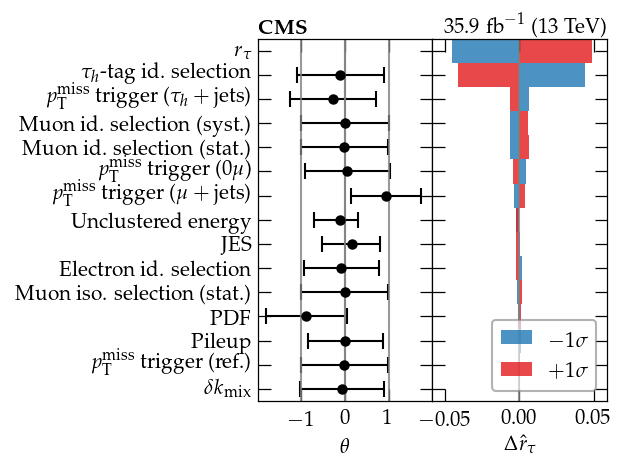

In [25]:
df = pd.DataFrame(results)
df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
df = df.sort_values("envelope").reset_index(drop=True).set_index(["param", "poi"])
selection = (
#    ~df.index.get_level_values("param").str.contains("mcstat")
    df.index.get_level_values("param").isin([
        "rWJetsToTauNuNorm",
        "tauIdTight", "metTrigSingleTauSyst", "metTrig0MuSyst",
        "muonIdTightStat", "eleIdIsoTight", "d2kqcd", "jesTotal",
        "metTrigSingleMuonSyst", "muonIdTightSyst", "unclust",
        "jer", "lhePdfWeight", "muonIsoTightStat", "pileup",
        "metTrigReferenceTriggerSyst", "d1kew", "lumi", "dkmix",
        "d2keww", "d3keww",
    ])
)
tdf = df.loc[selection,:].drop("envelope", axis=1).iloc[-15:]
tdf.loc[("rWJetsToTauNuNorm", "rWJetsToTauNuNorm"),"param_value"] = np.nan
conv = dftools.draw.nuisance_names
conv["rWJetsToTauNuNorm"] = r'$r_\tau$'
fig, ax = dftools.draw.draw_impacts(
    tdf, converter=conv
)

ax[0].text(
    0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom',
    transform=ax[0].transAxes,
)
ax[1].text(
    1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom',
    transform=ax[1].transAxes,
)
ax[1].set_xlabel(r'$\Delta \hat{r}_\tau$')
ax[1].legend(loc=4, fancybox=True, edgecolor="gray")
fig.set_size_inches(3,3.2)
fig.align_labels(ax)
fig.savefig("plots/impacts_tfmue2twj.pdf", format='pdf', bbox_inches='tight')

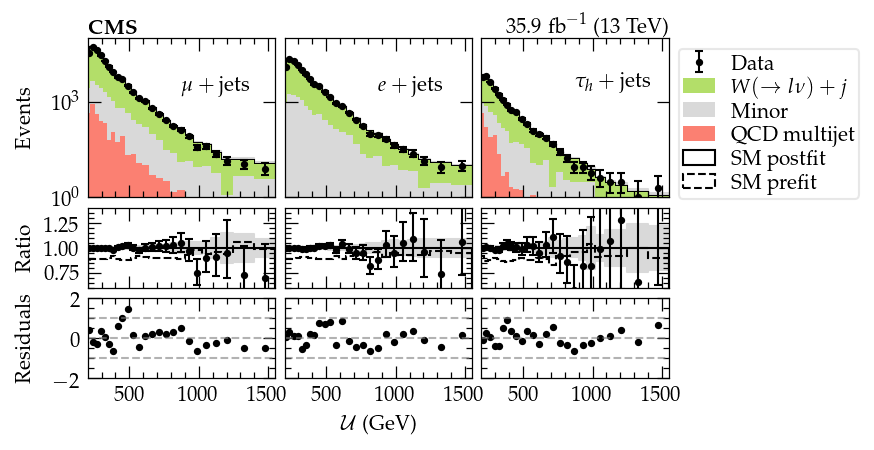

In [27]:
fig, ax = plt.subplots(
    figsize=(5, 3), dpi=150,
    nrows=3, ncols=3,
    sharex='col', sharey='row',
    gridspec_kw={
        "height_ratios": (2,1,1),
        "hspace": 0.1, "wspace": 0.05,
    },
)
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(model.bins["SingleMuon"][0][0], model.bins["SingleMuon"][1][-1])
ax[0,1].set_xlim(model.bins["SingleMuon"][0][0], model.bins["SingleMuon"][1][-1])
ax[0,2].set_xlim(model.bins["SingleMuon"][0][0], model.bins["SingleMuon"][1][-1])

model.draw_data("SingleMuon", ax[0,0], label="Data")
model.draw_prediction_total("SingleMuon", ax[0,0])
model.draw_prediction_procs("SingleMuon", ax[0,0])
model.draw_data("SingleMuon", ax[1,0], ratio=True)
model.draw_prediction_total("SingleMuon", ax[1,0], ratio=True, hkwargs={"label": "SM postfit"})
model.draw_prediction_total("SingleMuon", ax[1,0], ratio=True, prefit=True, band=False, hkwargs={"label": "SM prefit"})
model.draw_data("SingleMuon", ax[2,0], pull=True)

model.draw_data("SingleElectron", ax[0,1])
model.draw_prediction_total("SingleElectron", ax[0,1])
model.draw_prediction_procs("SingleElectron", ax[0,1])
model.draw_data("SingleElectron", ax[1,1], ratio=True)
model.draw_prediction_total("SingleElectron", ax[1,1], ratio=True)
model.draw_prediction_total("SingleElectron", ax[1,1], ratio=True, prefit=True, band=False)
model.draw_data("SingleElectron", ax[2,1], pull=True)

model.draw_data("SingleTau", ax[0,2])
model.draw_prediction_total("SingleTau", ax[0,2])
model.draw_prediction_procs("SingleTau", ax[0,2])
model.draw_data("SingleTau", ax[1,2], ratio=True)
model.draw_prediction_total("SingleTau", ax[1,2], ratio=True)
model.draw_prediction_total("SingleTau", ax[1,2], ratio=True, prefit=True, band=False)
model.draw_data("SingleTau", ax[2,2], pull=True)

ax[0,0].set_ylim(1, 1e5)
ax[1,0].set_ylim(0.6, 1.4)
ax[2,0].set_ylim(-2, 2)

ax[0,1].set_ylim(1, 1e5)
ax[1,1].set_ylim(0.6, 1.4)
ax[2,1].set_ylim(-2, 2)

ax[0,2].set_ylim(1, 1e5)
ax[1,2].set_ylim(0.6, 1.4)
ax[2,2].set_ylim(-2, 2)

ax[2,0].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,0].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,0].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[2,1].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,1].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,1].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[2,2].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,2].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,2].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[0,0].set_ylabel('Events')
ax[1,0].set_ylabel('Ratio')
ax[2,0].set_ylabel('Residuals')
#ax[2,0].set_xlabel('$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel('$\mathcal{U}$ (GeV)')
#ax[2,2].set_xlabel('$\mathcal{U}$ (GeV)')

h1, l1 = ax[0,0].get_legend_handles_labels()
h2, l2 = ax[1,0].get_legend_handles_labels()
ax[0,2].legend(
    h1[::-1]+h2, l1[::-1]+l2,
    loc=2, bbox_to_anchor=(1,1),
    fancybox=True, edgecolor="#d9d9d9",
    labelspacing=0.1, borderpad=0.2,
)

ax[0,0].text(0.5, 0.7, r'$\mu+\mathrm{jets}$', ha='left', va='center', transform=ax[0,0].transAxes)
ax[0,1].text(0.5, 0.7, r'$e+\mathrm{jets}$', ha='left', va='center', transform=ax[0,1].transAxes)
ax[0,2].text(0.5, 0.7, r'$\tau_h+\mathrm{jets}$', ha='left', va='center', transform=ax[0,2].transAxes)

ax[0,0].text(0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[0,0].transAxes)
ax[0,2].text(1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom', transform=ax[0,2].transAxes)
fig.align_labels(ax)
fig.savefig("plots/postfit_tfmue2twj.pdf", format="pdf", bbox_inches='tight')
pass

## View parameter effects

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


bin_min  bin_max
200.0    220.0      5463.062164
220.0    250.0      5470.691365
250.0    280.0      3658.814881
280.0    310.0      2390.288449
310.0    340.0      1553.628934
340.0    370.0      1012.770831
370.0    400.0       674.568138
400.0    430.0       462.885489
430.0    470.0       413.272883
470.0    510.0       268.721744
510.0    550.0       177.185407
550.0    590.0       108.501182
590.0    640.0        90.344830
640.0    690.0        65.858328
690.0    740.0        35.274398
740.0    790.0        25.858884
790.0    840.0        18.313434
840.0    900.0        15.091794
900.0    960.0        10.569098
960.0    1020.0        7.575714
1020.0   1090.0        3.644616
1090.0   1160.0        2.578920
1160.0   1250.0        2.155649
1250.0   1400.0        1.521689
1400.0   1550.0        1.017720
Name: prediction, dtype: float64


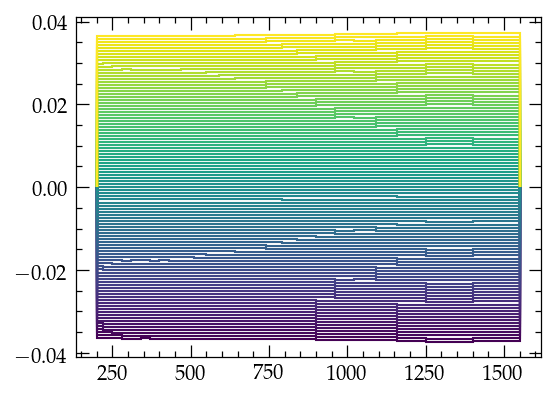

In [25]:
model = dftools.fitting.NLLModel2(df_data, df_mc, config, same_bin_widths=True)
parameters = model.parameters

region = "SingleTau"
#proc = "WJetsToLnu"
nuis = "tauIdTight"

nom = model.predictions(region)["prediction"]
print(nom)
binmin, binmax = model.bins[region]

fig, ax = plt.subplots()

ndiv = 100
cmap = plt.get_cmap('viridis', ndiv+1)

for idx, theta in enumerate(np.linspace(-1., 1., 101)):
    parameters[nuis] = theta
    model.set_parameters(parameters)
    vari = model.predictions(region)["prediction"]

    ax.hist(
        binmin, bins=list(binmin)+[binmax[-1]], weights=vari/nom-1,
        histtype='step', color=cmap(idx),
    )

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


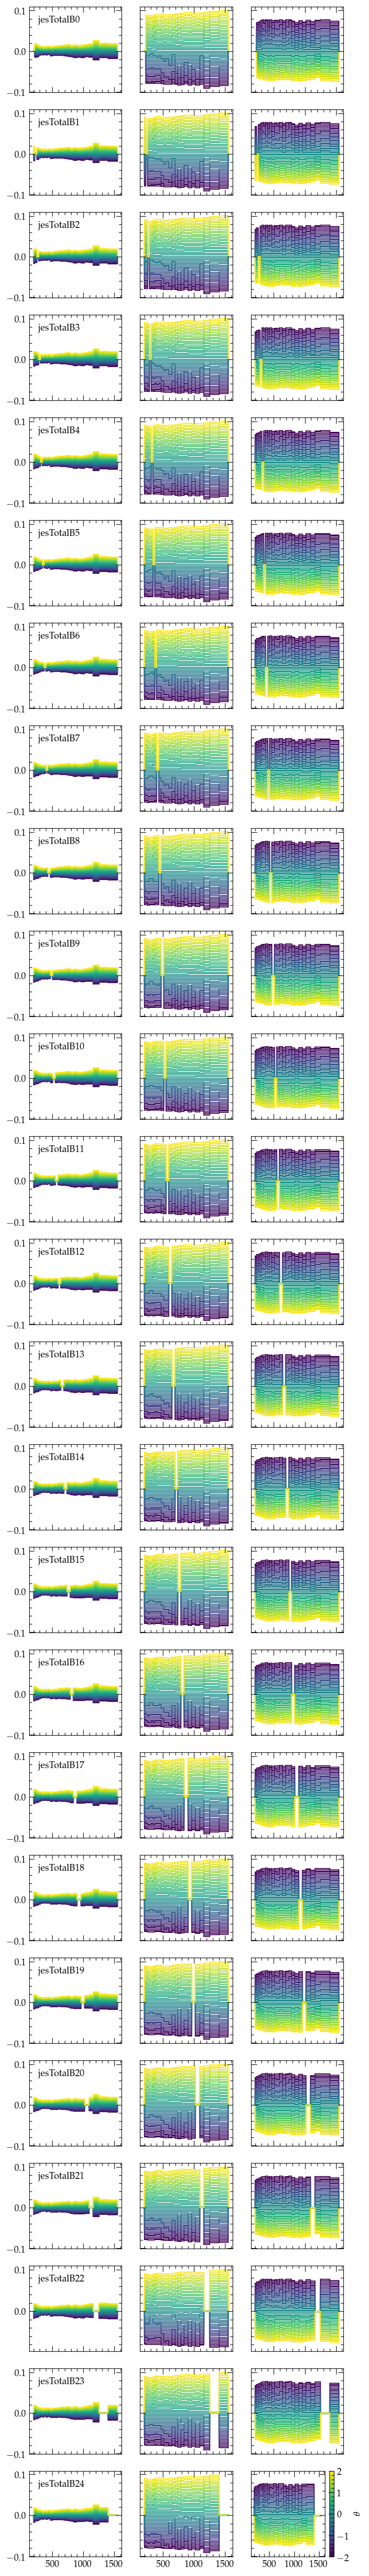

In [34]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
parameters = copy.deepcopy(model.parameters)

bins = model.bins["SingleMuon"]
#process = "WJetsToLNu"
pred_nom_m = model.predictions("SingleMuon")["prediction"].values #.loc[(process)].values
pred_nom_e = model.predictions("SingleElectron")["prediction"].values #.loc[(process)].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)

#nuisances = ["d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz", "dkmix"]
nuisances = [
    "jesTotalB0",
    "jesTotalB1",
    "jesTotalB2",
    "jesTotalB3",
    "jesTotalB4",
    "jesTotalB5",
    "jesTotalB6",
    "jesTotalB7",
    "jesTotalB8",
    "jesTotalB9",
    "jesTotalB10",
    "jesTotalB11",
    "jesTotalB12",
    "jesTotalB13",
    "jesTotalB14",
    "jesTotalB15",
    "jesTotalB16",
    "jesTotalB17",
    "jesTotalB18",
    "jesTotalB19",
    "jesTotalB20",
    "jesTotalB21",
    "jesTotalB22",
    "jesTotalB23",
    "jesTotalB24",
]
fig, ax = plt.subplots(
    figsize=(6, 2*len(nuisances)), dpi=150,
    nrows=len(nuisances), ncols=3,
    sharex=True, sharey='row',
)
    
for nidx, nuis in enumerate(nuisances):
    for idx, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams = copy.deepcopy(parameters)
        tparams[nuis] = theta
        model.set_parameters(tparams)
        pred_m = model.predictions("SingleMuon")["prediction"].values #.loc[(process)].values
        pred_e = model.predictions("SingleElectron")["prediction"].values #.loc[(process)].values
        
        if len(nuisances)>1:
            row = nidx
            tax = ax[row,0]
        else:
            tax = ax[0]
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred_m/pred_nom_m-1.,
            histtype='step',
            color=cmap(idx),
        )
        tax.legend([], [], loc=2, title=nuis)
        
        if len(nuisances)>1:
            tax = ax[row,1]
        else:
            tax = ax[1]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred_e/pred_nom_e-1.,
            histtype='step',
            color=cmap(idx),
        )
        
        if len(nuisances)>1:
            tax = ax[row,2]
        else:
            tax = ax[2]
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=((pred_m/pred_nom_m)/(pred_e/pred_nom_e))-1.,
            histtype='step',
            color=cmap(idx),
        )
        
        ylim = max(np.abs(tax.get_ylim()))
        if ylim < 1e-5:
            tax.set_ylim(-1e-3, 1e-3)
    
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=-2., vmax=2.)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.set_label(r'$\theta$')

KeyError: 'rWJets'

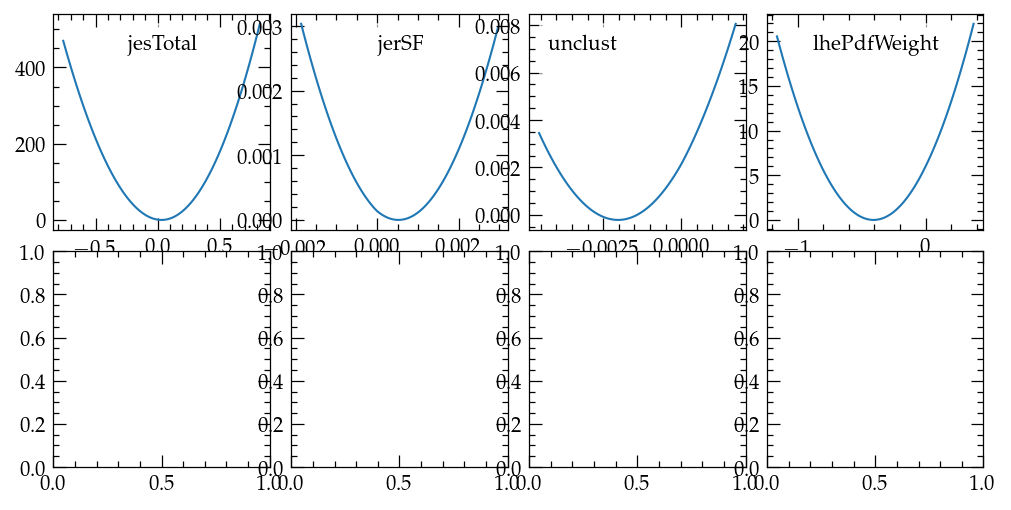

In [100]:
parameters = [
    "jesTotal", "jerSF", "unclust", "lhePdfWeight",
    "rWJets", "rWJetsToENuNorm", "rWJetsToENuShape",
]
nrows = (len(parameters)-1)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

pvals = dict(minimizer.values)
fval = minimizer.fval

for idx, param in enumerate(parameters):
    x, y = minimizer.profile(param, subtract_min=True)
    
    #bf_vals = results.set_index(["param"]).loc[param]
    #x = []
    #y = []
    #for theta in np.linspace(-2., 2., 21):
    #    _pvals = copy.deepcopy(pvals)
    #    _x = bf_vals["param_value"] + theta*((theta<0.)*np.abs(bf_vals["param_merrdown"]) + (theta>=0.)*bf_vals["param_merrup"])
    #    _pvals[param] = _x
    #    model.set_parameters(_pvals)
    #    x.append(_x)
    #    y.append(model.nll()-fval)
    
    row = idx//4
    col = idx%4
    ax[row,col].plot(x, y)
    ax[row,col].legend([], [], title=param)

In [28]:
parameters = copy.deepcopy(model.parameters)

def scan(x, y, p1, p2):
    tp = copy.deepcopy(parameters)
    tp[p1] = x
    tp[p2] = y
    return model(tp)

xs = np.linspace(0.5, 1.5, 21)
ys = np.linspace(-3., 3., 21)

X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)
for ix in range(xs.shape[0]):
    for iy in range(ys.shape[0]):
        Z[ix,iy] = scan(X[ix,iy], Y[ix,iy], "rWJetsToENuNorm", "metTrigSingleMuonSyst")

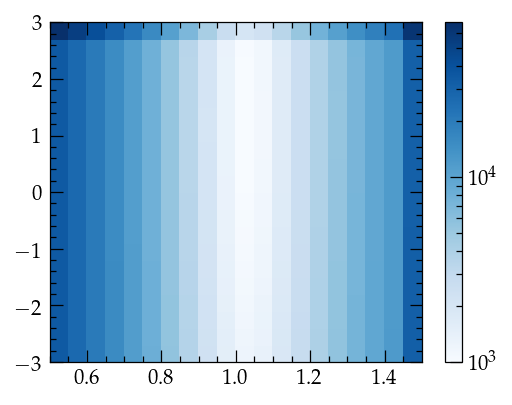

In [29]:
import matplotlib as mpl

fig, ax = plt.subplots()
h = ax.hist2d(
    X.ravel(), Y.ravel(),
    bins=(xs, ys),
    weights=Z.ravel(),
    norm=mpl.colors.LogNorm(),
    cmap="Blues",
)
cbar = fig.colorbar(h[3], ax=ax)
pass